In [60]:
import pandas as pd 
import numpy as np
import seaborn as sns

from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
from sklearn.svm import SVC

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, classification_report

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pickle
from imblearn.over_sampling import SMOTE


In [ ]:
df = pd.read_csv('../data/wine_quality_modelos2.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)
df

In [ ]:
# desordenamos la columna del tipo de vino para que no vaya en orden
df['wine_type'] = np.random.permutation(df['wine_type'].values)
df.to_csv('../data/wine_quality_modelos2.csv')
df

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   wine_type             6497 non-null   object 
 1   fixed acidity         6497 non-null   float64
 2   volatile acidity      6497 non-null   float64
 3   citric acid           6497 non-null   float64
 4   residual sugar        6497 non-null   float64
 5   chlorides             6497 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6497 non-null   float64
 10  sulphates             6497 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
 13  quality_category      6497 non-null   object 
dtypes: float64(11), int64(1), object(2)
memory usage: 710.7+ KB


In [62]:
st_scaler = StandardScaler()

# Separamos las features de las etiquetas 
X = df[['fixed acidity','volatile acidity','citric acid','residual sugar', 
        'chlorides', 'total sulfur dioxide', 'density', 'pH','sulphates','alcohol']]
y = df["quality_category"]

# Escalamos los datos
X_scaled = st_scaler.fit_transform(X)

smote = SMOTE(random_state=10)
X_res, y_res = smote.fit_resample(X_scaled, y)


In [64]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size = 0.2, random_state = 10, stratify=y_res)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(9396, 10)
(9396,)
(2349, 10)
(2349,)


# MODELO LOGISTIC REGRESSION

In [65]:
modelo_lr = LogisticRegression(
    max_iter=1000,  # Aumentar iteraciones para convergencia
    random_state=10,
    class_weight='balanced',
    multi_class='auto'  # Auto-detecta si es binario o multiclase
)
modelo_lr.fit(X_train, y_train)

c:\Users\amaci\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(class_weight='balanced', max_iter=1000, multi_class='auto',
                   random_state=10)

In [66]:
y_pred = modelo_lr.predict(X_test)
y_proba = modelo_lr.predict_proba(X_test)  # Probabilidades para todas las clases

In [67]:
# 1. Métricas básicas
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision (macro):", precision_score(y_test, y_pred, average='macro'))
print("Recall (macro):", recall_score(y_test, y_pred, average='macro'))
print("F1-Score (macro):", f1_score(y_test, y_pred, average='macro'))
accu_lr=accuracy_score(y_test, y_pred)

# 2. Matriz de confusión
print("\nMatriz de Confusión:")
print(confusion_matrix(y_test, y_pred))
cm_lr = confusion_matrix(y_test, y_pred)

# 3. Reporte completo (precision, recall, f1 por clase)
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))

# 4. ROC-AUC (para multiclase)
if len(modelo_lr.classes_) > 2:
    y_test_bin = pd.get_dummies(y_test).values  # One-hot encoding
    roc_auc_lr=roc_auc_score(y_test_bin, y_proba, multi_class='ovr')
else:
    print("ROC-AUC (Binario):", roc_auc_score(y_test, y_proba[:, 1]))
roc_auc_lr

Accuracy: 0.6181353767560664
Precision (macro): 0.6066286550431413
Recall (macro): 0.6181353767560664
F1-Score (macro): 0.608208366182011

Matriz de Confusión:
[[567  78 138]
 [ 47 581 155]
 [268 211 304]]

Reporte de Clasificación:
              precision    recall  f1-score   support

        alta       0.64      0.72      0.68       783
        baja       0.67      0.74      0.70       783
       media       0.51      0.39      0.44       783

    accuracy                           0.62      2349
   macro avg       0.61      0.62      0.61      2349
weighted avg       0.61      0.62      0.61      2349



np.float64(0.7877031991548807)

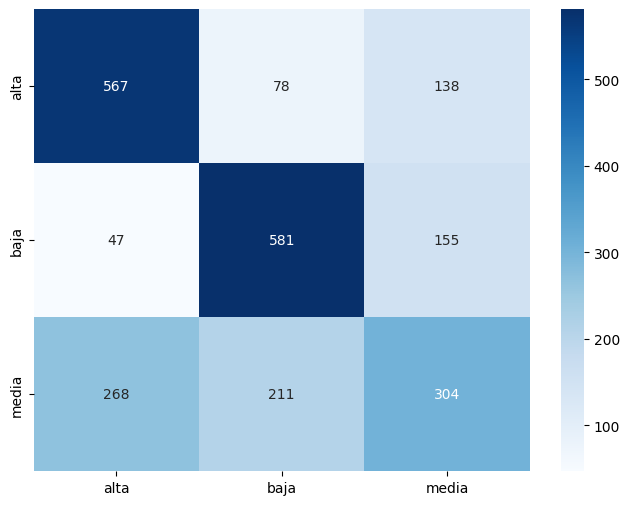

In [68]:
# Matriz de confusion
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(
    cm_lr, 
    annot=True, 
    fmt='d',          # 'd' = formato entero (sin decimales)
    cmap='Blues',     # Colores azules (puedes usar 'Reds', 'Greens', etc.)
    cbar=True,        # Muestra la barra de colores lateral
    xticklabels=['alta', 'baja', 'media'],  # Nombres de clases (¡ajústalos!)
    yticklabels=['alta', 'baja', 'media']   # Nombres de clases
)

In [69]:
y_test

6731      alta
4794     media
4005     media
1202      alta
1142     media
         ...  
6874      alta
1412     media
10857     baja
2728     media
4001     media
Name: quality_category, Length: 2349, dtype: object

In [70]:
y_test.value_counts()

quality_category
alta     783
media    783
baja     783
Name: count, dtype: int64

# MODELO RANDOM FOREST

In [72]:
modelo_rf = RandomForestClassifier(
    n_estimators=1000,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    class_weight='balanced',
    oob_score=True,
    random_state=10)

modelo_rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=2, min_samples_split=5,
                       n_estimators=1000, oob_score=True, random_state=10)

In [73]:
y_pred_rf = modelo_rf.predict(X_test)
y_proba_rf = modelo_rf.predict_proba(X_test) 

In [74]:
# 1. Métricas básicas
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Precision (macro):", precision_score(y_test, y_pred_rf, average='macro'))
print("Recall (macro):", recall_score(y_test, y_pred_rf, average='macro'))
print("F1-Score (macro):", f1_score(y_test, y_pred_rf, average='macro'))
accu_rf=accuracy_score(y_test, y_pred_rf)

# 2. Matriz de confusión
print("\nMatriz de Confusión:")
print(confusion_matrix(y_test, y_pred_rf)) 
cm_rf = confusion_matrix(y_test, y_pred_rf)

# 3. Reporte completo por clase
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_rf))

# 4. ROC-AUC (para multiclase)
if len(modelo_rf.classes_) > 2:
    y_test_bin = pd.get_dummies(y_test).values  # One-hot encoding
    roc_auc_rf=roc_auc_score(y_test_bin, y_proba_rf, multi_class='ovr')
else:
    print("ROC-AUC (Binario):", roc_auc_score(y_test, y_proba_rf[:, 1]))
roc_auc_rf

Accuracy: 0.8382290336313325
Precision (macro): 0.8375909347034994
Recall (macro): 0.8382290336313325
F1-Score (macro): 0.8330520142389907

Matriz de Confusión:
[[770   2  11]
 [ 11 681  91]
 [ 96 169 518]]

Reporte de Clasificación:
              precision    recall  f1-score   support

        alta       0.88      0.98      0.93       783
        baja       0.80      0.87      0.83       783
       media       0.84      0.66      0.74       783

    accuracy                           0.84      2349
   macro avg       0.84      0.84      0.83      2349
weighted avg       0.84      0.84      0.83      2349



np.float64(0.9541230283585799)

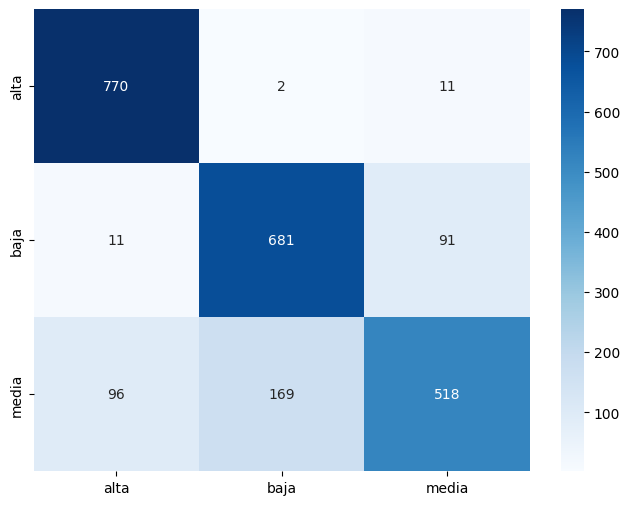

In [75]:
# Matriz de confusion
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(
    cm_rf, 
    annot=True, 
    fmt='d',          # 'd' = formato entero (sin decimales)
    cmap='Blues',     # Colores azules (puedes usar 'Reds', 'Greens', etc.)
    cbar=True,        # Muestra la barra de colores lateral
    xticklabels=['alta', 'baja', 'media'],  # Nombres de clases (¡ajústalos!)
    yticklabels=['alta', 'baja', 'media'] # Nombres de clases
)

# RANDOM FOREST CON GRIDSEARCH

In [76]:
rf = RandomForestClassifier()
parametros={
    "n_estimators":[50,100,150],
    "max_depth":[3,5,7,10,12],
    "max_features":[2,3,4],
    "bootstrap":[True, False]
}

gs_rfc = GridSearchCV(rf, parametros, scoring="accuracy", cv = 5, verbose=3, n_jobs=1)
gs_rfc.fit(X_train, y_train)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
[CV 1/5] END bootstrap=True, max_depth=3, max_features=2, n_estimators=50;, score=0.611 total time=   0.3s
[CV 2/5] END bootstrap=True, max_depth=3, max_features=2, n_estimators=50;, score=0.642 total time=   0.2s
[CV 3/5] END bootstrap=True, max_depth=3, max_features=2, n_estimators=50;, score=0.617 total time=   0.3s
[CV 4/5] END bootstrap=True, max_depth=3, max_features=2, n_estimators=50;, score=0.625 total time=   0.2s
[CV 5/5] END bootstrap=True, max_depth=3, max_features=2, n_estimators=50;, score=0.616 total time=   0.2s
[CV 1/5] END bootstrap=True, max_depth=3, max_features=2, n_estimators=100;, score=0.611 total time=   0.6s
[CV 2/5] END bootstrap=True, max_depth=3, max_features=2, n_estimators=100;, score=0.638 total time=   0.7s
[CV 3/5] END bootstrap=True, max_depth=3, max_features=2, n_estimators=100;, score=0.615 total time=   0.6s
[CV 4/5] END bootstrap=True, max_depth=3, max_features=2, n_estimators=100;, sc

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [3, 5, 7, 10, 12],
                         'max_features': [2, 3, 4],
                         'n_estimators': [50, 100, 150]},
             scoring='accuracy', verbose=3)

In [77]:
print(gs_rfc.best_estimator_)
print(gs_rfc.best_score_)

RandomForestClassifier(bootstrap=False, max_depth=12, max_features=4,
                       n_estimators=150)
0.8550454066785184


In [78]:
modelo_rf_gs = RandomForestClassifier(
    n_estimators=150,
    max_depth=12,
    max_features=4,
    class_weight='balanced',
    random_state=10)

modelo_rf_gs.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=12, max_features=4,
                       n_estimators=150, random_state=10)

In [79]:
y_pred_rf_gs = modelo_rf_gs.predict(X_test)
y_proba_rf_gs = modelo_rf_gs.predict_proba(X_test) 

In [80]:
# 1. Métricas básicas
print("Accuracy:", accuracy_score(y_test, y_pred_rf_gs))
print("Precision (macro):", precision_score(y_test, y_pred_rf_gs, average='macro'))
print("Recall (macro):", recall_score(y_test, y_pred_rf_gs, average='macro'))
print("F1-Score (macro):", f1_score(y_test, y_pred_rf_gs, average='macro'))
accu_rf_gs=accuracy_score(y_test, y_pred_rf_gs)

# 2. Matriz de confusión
print("\nMatriz de Confusión:")
print(confusion_matrix(y_test, y_pred_rf_gs)) 
cm_rf_gs = confusion_matrix(y_test, y_pred_rf_gs)

# 3. Reporte completo por clase
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_rf_gs))

# 4. ROC-AUC (para multiclase)
if len(modelo_rf_gs.classes_) > 2:
    y_test_bin = pd.get_dummies(y_test).values  # One-hot encoding
    roc_auc_rf_gs=roc_auc_score(y_test_bin, y_proba_rf_gs, multi_class='ovr')
else:
    print("ROC-AUC (Binario):", roc_auc_score(y_test, y_proba_rf_gs[:, 1]))
roc_auc_rf_gs

Accuracy: 0.8641975308641975
Precision (macro): 0.864430895777408
Recall (macro): 0.8641975308641975
F1-Score (macro): 0.8608364794601536

Matriz de Confusión:
[[774   3   6]
 [  7 696  80]
 [ 70 153 560]]

Reporte de Clasificación:
              precision    recall  f1-score   support

        alta       0.91      0.99      0.95       783
        baja       0.82      0.89      0.85       783
       media       0.87      0.72      0.78       783

    accuracy                           0.86      2349
   macro avg       0.86      0.86      0.86      2349
weighted avg       0.86      0.86      0.86      2349



np.float64(0.9672203655043013)

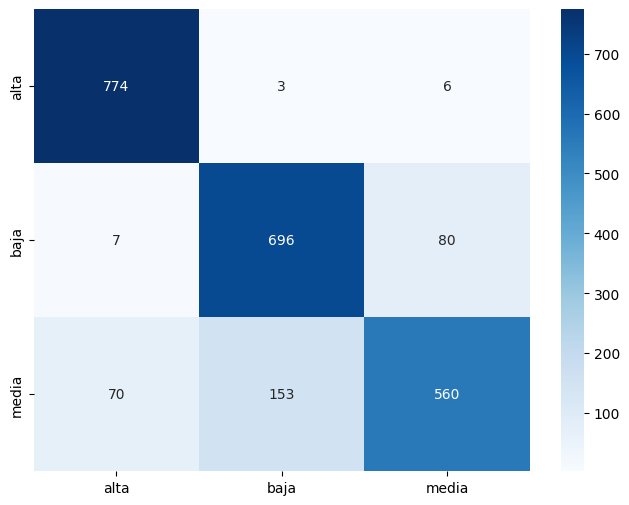

In [81]:
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap( 
    cm_rf_gs, 
    annot=True, 
    fmt='d',          # 'd' = formato entero (sin decimales)
    cmap='Blues',     # Colores azules (puedes usar 'Reds', 'Greens', etc.)
    cbar=True,        # Muestra la barra de colores lateral
    xticklabels=['alta', 'baja', 'media'],  # Nombres de clases (¡ajústalos!)
    yticklabels=['alta', 'baja', 'media'] # Nombres de clases
)

# MODELO ADABOOST

In [83]:
from sklearn.ensemble import AdaBoostClassifier

dt = DecisionTreeClassifier(max_depth=12)
modelo_abc = AdaBoostClassifier(
    estimator=dt, 
    n_estimators=150, 
    learning_rate=0.5,
    random_state=10)
 
modelo_abc.fit(X_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=12),
                   learning_rate=0.5, n_estimators=150, random_state=10)

In [84]:
y_pred_abc = modelo_abc.predict(X_test)
y_proba_abc = modelo_abc.predict_proba(X_test) 

In [86]:
# 1. Métricas básicas
print("Accuracy:", accuracy_score(y_test, y_pred_abc))
print("Precision (macro):", precision_score(y_test, y_pred_abc, average='macro'))
print("Recall (macro):", recall_score(y_test, y_pred_abc, average='macro'))
print("F1-Score (macro):", f1_score(y_test, y_pred_abc, average='macro'))
accu_abc=accuracy_score(y_test, y_pred_abc)

# 2. Matriz de confusión
print("\nMatriz de Confusión:")
print(confusion_matrix(y_test, y_pred_abc)) 
cm_rf_abc = confusion_matrix(y_test, y_pred_abc)


# 4. Reporte completo por clase
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_abc))

# 4. ROC-AUC (para multiclase)
if len(modelo_abc.classes_) > 2:
    y_test_bin = pd.get_dummies(y_test).values  # One-hot encoding
    roc_auc_abc=roc_auc_score(y_test_bin, y_proba_abc, multi_class='ovr')
else:
    print("ROC-AUC (Binario):", roc_auc_score(y_test, y_proba_abc[:, 1]))
roc_auc_abc

Accuracy: 0.9063431247339293
Precision (macro): 0.9063152787007597
Recall (macro): 0.9063431247339294
F1-Score (macro): 0.9059719720946572

Matriz de Confusión:
[[776   0   7]
 [  0 701  82]
 [ 15 116 652]]

Reporte de Clasificación:
              precision    recall  f1-score   support

        alta       0.98      0.99      0.99       783
        baja       0.86      0.90      0.88       783
       media       0.88      0.83      0.86       783

    accuracy                           0.91      2349
   macro avg       0.91      0.91      0.91      2349
weighted avg       0.91      0.91      0.91      2349



np.float64(0.9798074450310912)

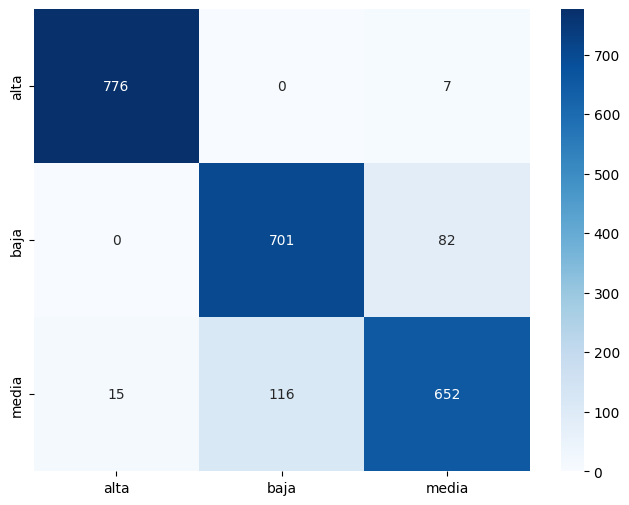

In [87]:
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(
    cm_rf_abc, 
    annot=True, 
    fmt='d',          # 'd' = formato entero (sin decimales)
    cmap='Blues',     # Colores azules (puedes usar 'Reds', 'Greens', etc.)
    cbar=True,        # Muestra la barra de colores lateral
    xticklabels=['alta', 'baja', 'media'],  # Nombres de clases (¡ajústalos!)
    yticklabels=['alta', 'baja', 'media'] # Nombres de clases
)

# MODELO XGBOOST

In [88]:
from sklearn.preprocessing import LabelEncoder

# Crear y ajustar el encoder
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)  # Convierte ['alta', 'baja', 'media'] → [0, 1, 2]

# Aplicar el mismo encoder a y_test (si lo tienes)
y_test_encoded = le.transform(y_test)

In [89]:
conteo = pd.Series(y_test_encoded).value_counts().sort_index()
conteo

0    783
1    783
2    783
Name: count, dtype: int64

In [90]:
from xgboost import XGBClassifier

modelo_xgb = XGBClassifier(
    n_estimators = 1000, 
    random_state = 10, 
    learning_rate = 0.5,
    objective='multi:softmax',  # Necesario para multiclase
    num_class=3)

modelo_xgb.fit(X_train, y_train_encoded)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.5, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=None, num_class=3, ...)

In [34]:
y_pred_encoded = modelo_xgb.predict(X_test)
y_pred_xgb= le.inverse_transform(y_pred_encoded) 
y_proba_xgb = modelo_xgb.predict_proba(X_test) 

In [ ]:
# 1. Métricas básicas
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Precision (macro):", precision_score(y_test, y_pred_xgb, average='macro'))
print("Recall (macro):", recall_score(y_test, y_pred_xgb, average='macro'))
print("F1-Score (macro):", f1_score(y_test, y_pred_xgb, average='macro'))
accu_xgb=accuracy_score(y_test, y_pred_xgb)

# 2. Matriz de confusión
print("\nMatriz de Confusión:")
print(confusion_matrix(y_test, y_pred_xgb)) 
cm_rf_xgb = confusion_matrix(y_test, y_pred_xgb)

# 4. Reporte completo por clase
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_xgb))

# 4. ROC-AUC (para multiclase)
if len(modelo_xgb.classes_) > 2:
    y_test_bin = pd.get_dummies(y_test).values  # One-hot encoding
    roc_auc_xgb = roc_auc_score(y_test_bin, y_proba_xgb, multi_class='ovr')
else:
    print("ROC-AUC (Binario):", roc_auc_score(y_test, y_proba_xgb[:, 1]))
roc_auc_xgb

ValueError: Found input variables with inconsistent numbers of samples: [2349, 1300]

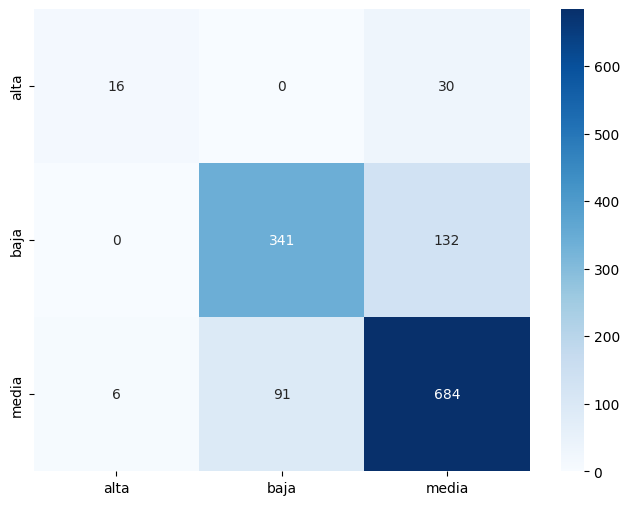

In [36]:
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(
    cm_rf_xgb, 
    annot=True, 
    fmt='d',          # 'd' = formato entero (sin decimales)
    cmap='Blues',     # Colores azules (puedes usar 'Reds', 'Greens', etc.)
    cbar=True,        # Muestra la barra de colores lateral
    xticklabels=['alta', 'baja', 'media'],  # Nombres de clases (¡ajústalos!)
    yticklabels=['alta', 'baja', 'media'] # Nombres de clases
)

# COMPARAMOS

In [92]:
roc_auc_values = [roc_auc_lr, roc_auc_rf, roc_auc_rf_gs, roc_auc_abc, roc_auc_xgb]  
accuracy_values = [accu_lr, accu_rf, accu_rf_gs, accu_abc, accu_xgb]  

df_resultados = pd.DataFrame({'ROC AUC': roc_auc_values,'ACCURACY': accuracy_values}, 
                             index=[
                                 'LogisticRegression',
                                 'RandomForestClassifier',
                                 'RandomForestClassifier_GS',
                                 'AdaBoostClassifier',
                                 'XGBClassifier']
                             )

df_resultados = df_resultados.sort_values('ROC AUC', ascending=False)
print(df_resultados)

                            ROC AUC  ACCURACY
AdaBoostClassifier         0.979807  0.906343
RandomForestClassifier_GS  0.967220  0.864198
RandomForestClassifier     0.954123  0.838229
XGBClassifier              0.881269  0.800769
LogisticRegression         0.787703  0.618135


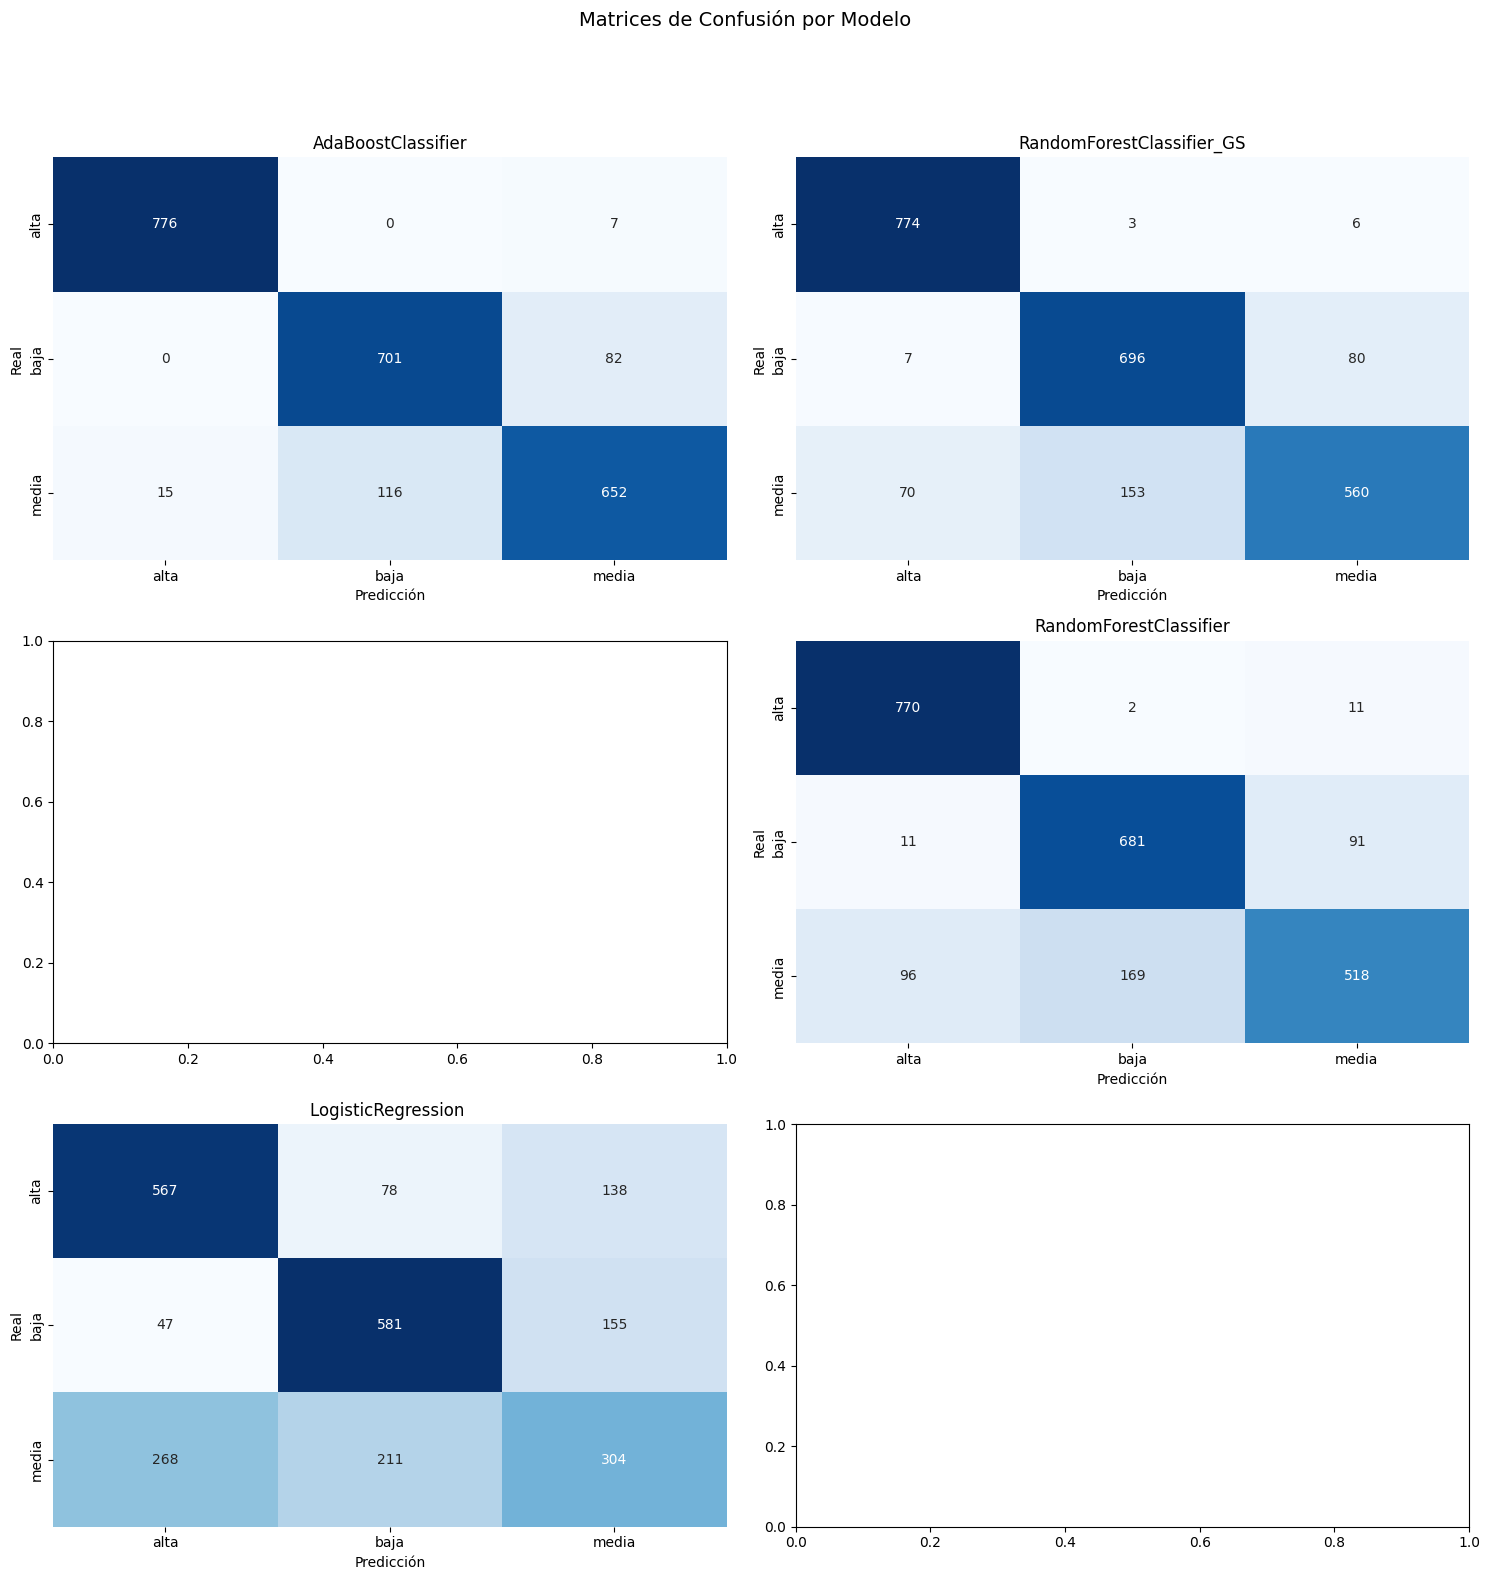

In [95]:
cm_lr = confusion_matrix(y_test, y_pred)
cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_rf_gs = confusion_matrix(y_test, y_pred_rf_gs)
cm_rf_abc = confusion_matrix(y_test, y_pred_abc)
#cm_rf_xgb = confusion_matrix(y_test, y_pred_xgb)


# Configuración común
labels = ['alta', 'baja', 'media']  # Etiquetas de clases
fig, axes = plt.subplots(3, 2, figsize=(15, 15))  # 3 fila, 2 columnas
plt.suptitle('Matrices de Confusión por Modelo', fontsize=14, y=1.05)

# Función para generar heatmap
def plot_confusion_matrix(cm, ax, title):
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        cbar=False,
        xticklabels=labels,
        yticklabels=labels,
        ax=ax
    )
    ax.set_title(title)
    ax.set_xlabel('Predicción')
    ax.set_ylabel('Real')

# Plotear cada matriz
plot_confusion_matrix(cm_rf_abc, axes[0, 0], 'AdaBoostClassifier')
plot_confusion_matrix(cm_rf_gs, axes[0, 1], 'RandomForestClassifier_GS')
#plot_confusion_matrix(cm_rf_xgb, axes[1, 0], 'XGBClassifier ')
plot_confusion_matrix(cm_rf, axes[1, 1], 'RandomForestClassifier')
plot_confusion_matrix(cm_lr, axes[2, 0], 'LogisticRegression ')

# Ajustar espacio entre subplots
plt.tight_layout()
plt.show()


# FEATURES IMPORTANCES

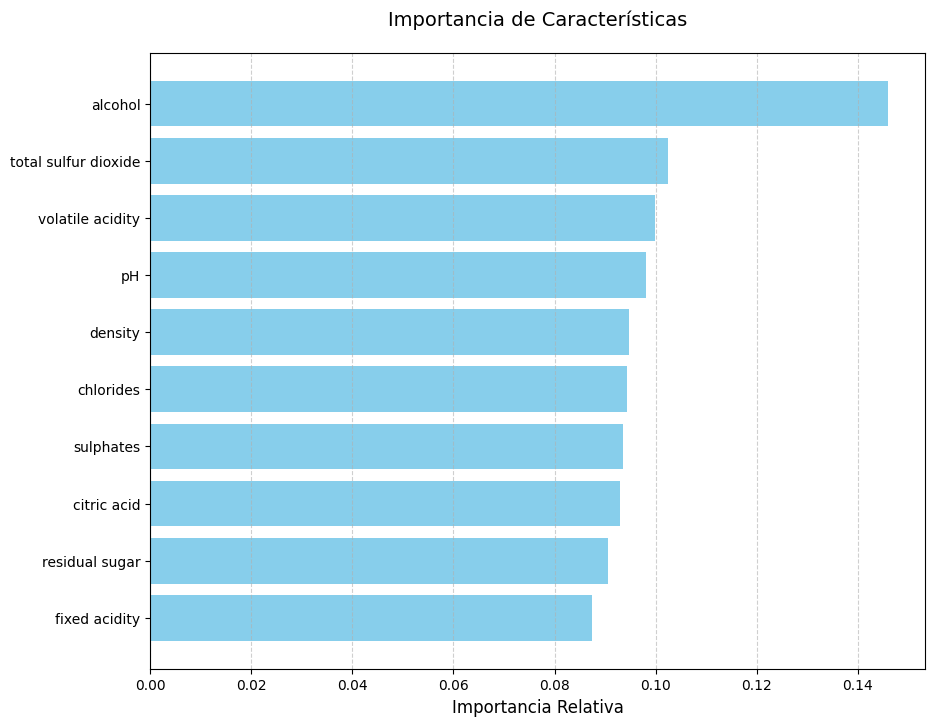

In [96]:
importances = modelo_abc.feature_importances_
feature_names = ['fixed acidity','volatile acidity','citric acid','residual sugar', 
        'chlorides', 'total sulfur dioxide', 'density', 'pH','sulphates','alcohol'] 

# 2. Ordenar características por importancia (de mayor a menor)
indices = np.argsort(importances)[::-1]
sorted_importances = importances[indices]
sorted_features = [feature_names[i] for i in indices]

# 3. Crear gráfico de barras horizontal
plt.figure(figsize=(10, 8))
plt.barh(range(len(importances)), sorted_importances, align='center', color='skyblue')
plt.yticks(range(len(importances)), sorted_features)
plt.gca().invert_yaxis()  # Invertir eje Y para mostrar la más importante arriba
plt.xlabel('Importancia Relativa', fontsize=12)
plt.title('Importancia de Características', fontsize=14, pad=20)
plt.grid(axis='x', linestyle='--', alpha=0.6)


In [99]:
# Confusion matrix con todos los datos
'''
cm_rf_abc
cm_rf_gs
cm_rf_xgb
cm_rf
cm_lr
'''

y_pred_abc = modelo_abc.predict(X_res)
print("\nMatriz de Confusión:")
print(confusion_matrix(y_res, y_pred_abc)) 
cm_rf_total = confusion_matrix(y_res, y_pred_abc)


Matriz de Confusión:
[[3908    0    7]
 [   0 3833   82]
 [  15  116 3784]]


# GUARDAMOS LOS NUEVOS MODELOS

In [ ]:
with open('../models/modelo_abc1.pkl', 'wb') as archivo:  # 'wb' = modo escritura binaria
    pickle.dump(modelo_abc, archivo)

print("Modelo guardado como 'modelo_abc1.pkl'")

In [ ]:
with open('../models/modelo_rf_gs1.pkl', 'wb') as archivo:  # 'wb' = modo escritura binaria
    pickle.dump(modelo_rf_gs, archivo)

print("Modelo guardado como 'modelo_rf_gs1.pkl'")

In [ ]:
with open('../models/modelo_xgb1.pkl', 'wb') as archivo:  # 'wb' = modo escritura binaria
    pickle.dump(modelo_xgb, archivo)

print("Modelo guardado como 'modelo_xgb1.pkl'")

In [ ]:
with open('../models/modelo_rf1.pkl', 'wb') as archivo:  # 'wb' = modo escritura binaria
    pickle.dump(modelo_rf, archivo)

print("Modelo guardado como 'modelo_rf1.pkl'")